# Trabalho Prático 3

 ## Ex. : 

In [ ]:
!pip install z3-solver
from z3 import *


1. A componente discreta do autómato contém os modos:  *Start*,  *Free*,  *Stopping*, *Blocked*, e *Stopped*. No modo *Free*  não existe qualquer força de travagem; no modo *Stopping* aplica-se a força de travagem alta; no modo *Blocked* as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo *Stopped* o veículo está imobilizado.


2. A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  *velocidade do corpo*  do veículo em relação ao solo e a* velocidade linear das rodas* também em relação ao solo. 
    Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equaçoes de Fluxo.


3. Os “switchs” (“jumps”) são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.


Variáveis que serão necessárias.
> v_inicial -> velocidade inicial

> p -> peso do veículo;

> a -> constante de atrito;

> b -> constante positiva de atrito no contacto corpo/ar;

> C -> constante de proporcionalidade c no modo *Stopping* é elevada;

> c -> constante de proporcionalidade c nos restantes modos é baixa;

> l -> variável usada para certificar a paragem, pois os cálculos uttilizados podem não dar 0;

> timer -> impede que se fique mais de $\,\tau\,$ segundos num certo modo.

In [ ]:
Mode, (Start,Free,Stopping,Blocked,Stopped) = EnumSort('Mode', ('Start','Free','Stopping','Blocked','Stopped'))
#Variáveis
v_inicial = 200
P = 1500
a = 0.3
b = 0.9
C = 6
c = 1
l = 0.5
timer = 0.2


4. 
    >a) Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.

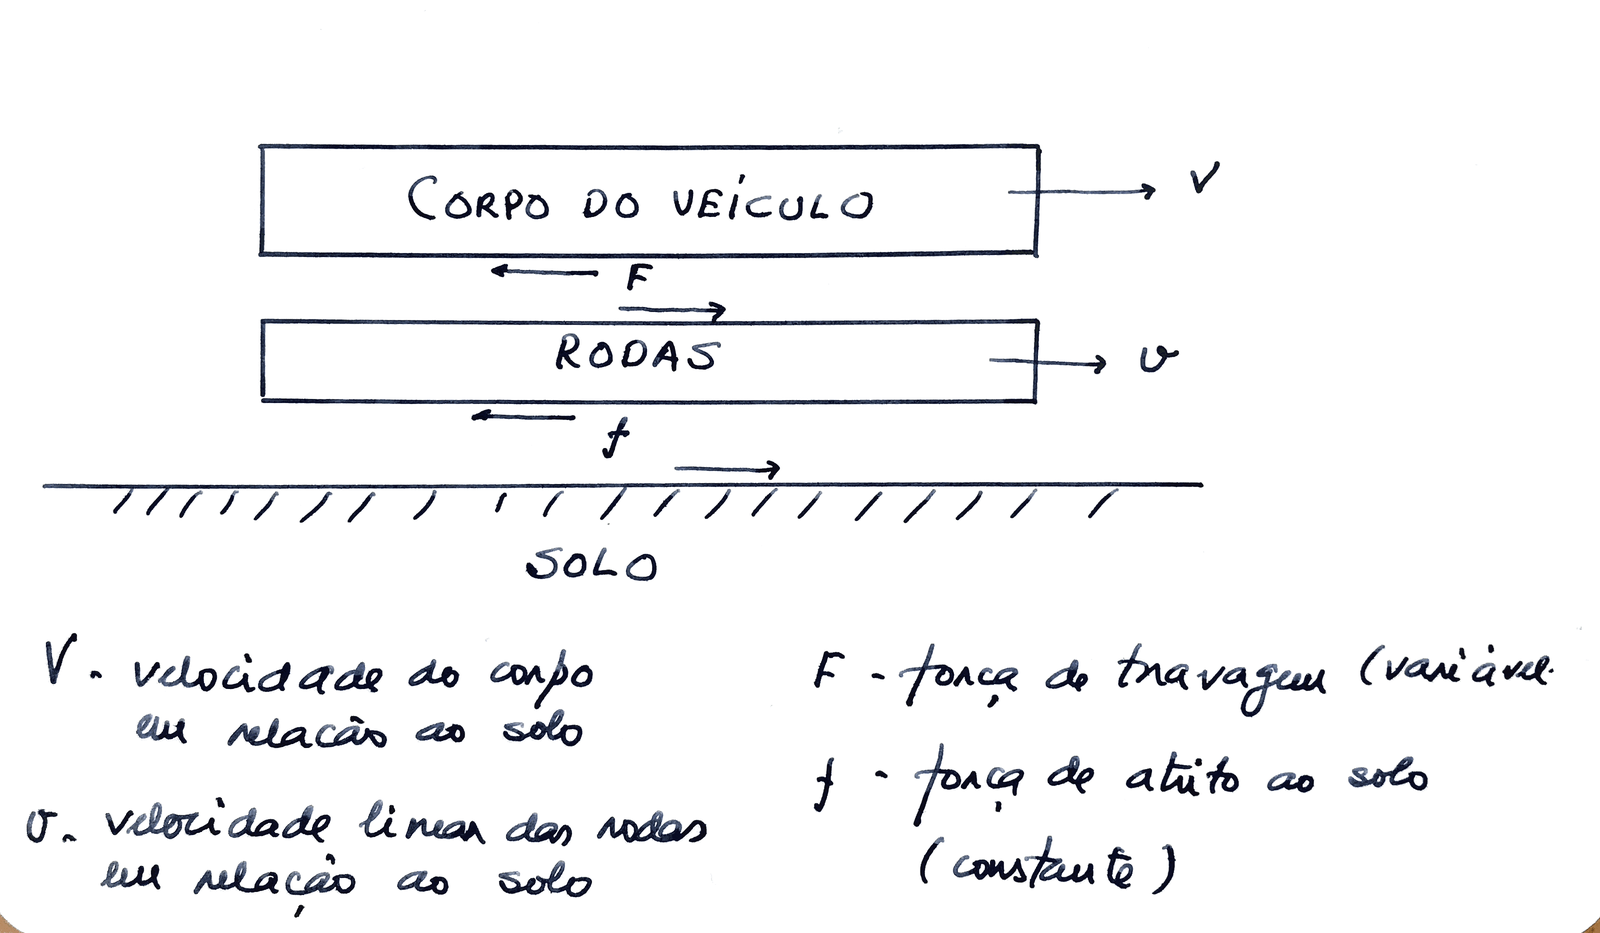

####Equações de Fluxo 

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 
2. No contacto rodas/solo o atrito é constante porque a força de compressão é o peso; tem-se $f = a\cdot P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos são fixos e independentes do modo.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades  $F =  c\cdot (V-v)$.  A  constante de proporcionalidade $c$ depende do modo: é elevada no modo *Stopping* e baixa nos outros.
4. Existe um atrito no contacto corpo/ar  que é aproximado por uma constante positiva $\,b$.


5. As equações que traduzem a dinâmica  do sistema são, em todos os modo excepto *Blocked*,
$$\begin{array}{rcl} \dot{V} & = & - c\cdot(V-v) - b\\ \dot{v} & = & -a\cdot P  + c\cdot(V-v) \end{array}$$ e , no modo *Blocked*,  a dinâmica do sistema é  regida por

$$(V = v) \;\land\; (\,\dot{V}\,=\, -a\cdot P - b\,)$$


6. Tanto no modo *Blocked*  como no modo *Free*  existe um “timer” que impede que se permaneça nesses modo mais do que $\,\tau\,$segundos. Os $\mathsf{jumps}(V,v,t,V',v',t')\,$ com origem nesses modos devem forçar esta condição.
7. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ é o “input” do problema.

Usamos a função *declare* para declarar as variáveis do *FOTS* correspondente ao sistema *ABS*.


In [ ]:
def declare(i):
    s = {}
    s['m'] = Const('m'+str(i),Mode)
    s['V'] = Real('V'+str(i))
    s['v'] = Real('v'+str(i))
    s['t'] = Real('t'+str(i))
    s['timer'] = Real('timer'+str(i))
    return s

Usamos também as funções *init* e *trans* que caractetizam correspondentemente os estados iniciais e as transições do *FOTS*.

####Transições untimed:


> *Start* $⟶$ *Stopping*
>> $m = Start \land\ m' = Stopping \land\ V = V' \land\ v = v' \land\ t = t'$

> *Stopping* $⟶$ *Blocked*
>> $m = Stopping \land\ m' = Blocked \land\ V-v<l \land\ V = V' \land\ v = v' \land\ V > 0 \land\ v \ge 0 \land\ timer' = 0 \land\ t = t'$

> *Stopping* $⟶$ *Stopped*
>> $m = Stopping \land\ m' = Stopped \land\ V < l \land\ v < l \land\ V' = 0 \land\ v' = 0  \land\ t = t'$

> *Blocked* $⟶$ *Free*
>> $m = Blocked \land\ m' = Free \land\ V = V' \land\ v = v' \land\ V > 0 \land\ v \ge 0 \land\ timer >= timer \land\ timer'== 0 \land\ t = t'$

> *Blocked* $⟶$ *Stopped*
>> $m = Blocked \land\ m' = Stopped \land\ V < l \land\ v < l \land\ V' = 0 \land\ v' = 0  \land\ t = t'$

> *Free* $⟶$ *Stopping* 
>> $m = Free \land\ m' = Stopping \land\ V = V' \land\ v = v' \land\ V > 0 \land\ v \ge 0 \land\ timer >= timer \land\ t = t'$

> *Free* $⟶$ *Stopped*
>> $m = Free \land\ m' = Stopped \land\ V < l \land\ v < l \land\ V' = 0 \land\ v' = 0  \land\ t = t'$

> *Stopped* $⟶$ *Stopped*
>> $m = Stopped \land\ m' = Stopped \land\ V = V' \land\ v = v'  \land\ t = t'$

####Transições timed:

> *Stopping* $⟶$ *Stopping*
>>$ m=Stopping \land\ m'=Stopping \land\ V-v>=l \land\ V'>=0 \land\ v'>=0\land\ V' ==(-C*(V-v)-b)*(t'-t) \land\ v' ==(-a*P+C*(v-v))*(t'-t),t'>t$

> *Free* $⟶$ *Free*
>>$ m=Free \land\ m'=Free \land\ V>=0 \land\ v'>=0 \land\ V' >= 0 \land\ v'>=0 \land\ timer'<=timer \land\ timer'==timer+t'-t \land\ V' ==(-C*(V-v)-b)*(t'-t) \land\ v' ==(-a*P+C*(v-v))*(t'-t),t'>t$

> *Blocked* $⟶$ *Blocked*
>>$ m=Blocked \land\ m'=Blocked \land\ V>=0 \land\ v>=0 \land\ V'>=0 \land\ v'>=0 \land\ timer'<=timer \land\  timer'==timer+t'-t \land\ V'=V+(-a*P-b)*(t'-t) \land\ v' = V' \land\ t'>t$



In [ ]:
def init(s):
    return (And(s['m']==Start,s['v']==v_inicial,s['V']==v_inicial,s['t']==0,))

def trans(s,p):
    #untimed
    startstopping = And(s['m']==Start,p['m']==Stopping,s['V']==p['V'],s['v']==p['v'],s['t']==p['t'])
    stoppingblocked = And(s['m']==Stopping,p['m']==Blocked,s['V']-s['v']<l,s['V']==p['V'],s['v']==p['v'],s['V'] > 0, s['v'] >=0, p['timer']==0,s['t']==p['t'])
    stoppingstopped = And(s['m']==Stopping,p['m']==Stopped,s['V']<l,s['v']<l,p['V']==0,p['v']==0,s['t']==p['t'])
    blockedfree = And(s['m']==Blocked,p['m']==Free,s['V']==p['V'],s['v']==p['v'],s['V'] > 0, s['v'] >=0,s['timer']>=timer,p['timer']==0,s['t']==p['t'])
    blockedstopped = And(s['m']==Blocked,p['m']==Stopped,s['V']<l,s['v']<l,p['V']==0,p['v']==0,s['t']==p['t'])
    freestopping = And(s['m']==Free,p['m']==Stopping,s['V']==p['V'],s['v']==p['v'],s['V']>0,s['v']>=0,s['timer']>=timer,s['t']==p['t'])
    freestopped = And(s['m']==Stopped,p['m']==Stopped,s['V']<l,s['v']<l,p['V']==0,p['v']==0,s['t']==p['t'])
    stoppedstopped = And(s['m']==Stopped,p['m']==Stopped,s['V']==p['V'],s['v']==p['v'],s['t']==p['t'])

    #timed
    stoppingstopping = And(s['m']==Stopping,p['m']==Stopping,s['V']-s['v']>=l,p['V']>=0, p['v']>=0,p['V']==(-C*(s['V']-s['v'])-b)*(p['t']-s['t']),p['v']==(-a*P+C*(s['V']-s['v']))*(p['t']-s['t']),p['t']>s['t'])
    freefree = And(s['m']==Free,p['m']==Free, s['V']>=0,s['v']>=0,p['V']>=0, p['v']>=0,p['timer']<=timer,p['timer']==s['timer']+p['t']-s['t'],p['V']==(-c*(s['V']-s['v'])-b)*(p['t']-s['t']),p['v']==(-a*P+c*(s['V']-s['v']))*(p['t']-s['t']),p['t']>s['t'])
    blockedblocked = And(s['m']==Blocked,p['m']==Blocked,s['V']>=0,s['v']>=0,p['V']>=0, p['v']>=0,p['timer']<=timer,p['timer']==s['timer']+p['t']-s['t'],p['V'] == s['V']+(-a*P -b)*(p['t']-s['t']),p['v'] == p['V'],p['t']>s['t']) 

    return Or(startstopping,stoppingblocked,stoppingstopped,blockedfree,blockedstopped,freestopping,freestopped,stoppingstopping,freefree,blockedblocked)


A função *gera_traco* imprime todas as variáveis contínuas como números de virgula flutuante.

In [ ]:
def gera_traco(declare,init,trans,k):
    s = Solver()
    
    trace = [declare(i) for i in range(k)]
    
    s.add(init(trace[0]))
    
    for i in range(k-1):
        s.add(trans(trace[i],trace[i+1]))
 
    if s.check()==sat: 
        m = s.model()
        for i in range(k):
            print(i)
            for v in trace[i]:
                if v != "timer":
                  if m[trace[i][v]].sort() == RealSort():
                    print(v,'=',float(m[trace[i][v]].numerator_as_long())/float(m[trace[i][v]].denominator_as_long()))
                  else:
                    print(v,'=',m[trace[i][v]])

    elif s.check() == unsat:
        print("Não é possivel executar")

gera_traco(declare,init,trans,10)

0
m = Start
V = 200.0
v = 200.0
t = 0.0
1
m = Stopping
V = 200.0
v = 200.0
t = 0.0
2
m = Blocked
V = 200.0
v = 200.0
t = 0.0
3
m = Blocked
V = 187.11714285714285
v = 187.11714285714285
t = 0.02857142857142857
4
m = Blocked
V = 174.2342857142857
v = 174.2342857142857
t = 0.05714285714285714
5
m = Blocked
V = 161.35142857142858
v = 161.35142857142858
t = 0.08571428571428572
6
m = Blocked
V = 148.46857142857144
v = 148.46857142857144
t = 0.11428571428571428
7
m = Blocked
V = 135.5857142857143
v = 135.5857142857143
t = 0.14285714285714285
8
m = Blocked
V = 122.70285714285714
v = 122.70285714285714
t = 0.17142857142857143
9
m = Blocked
V = 109.82
v = 109.82
t = 0.2


>b) Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema. 

A função *bmc_always* é utilizada para, quando aparece um contra-tempo, imprime todas as variáveis continuas como números de vírgula flutuante.

In [ ]:
def bmc_always(declare,init,trans,inv,K):
    for k in range(1,K+1):
        s = Solver()
        trace = [declare(i) for i in range(k)]
        
        s.add(init(trace[0]))
        for i in range(k-1):
            s.add(trans(trace[i],trace[i+1]))
        
        s.add(Not(inv(trace[k-2],trace[k-1])))

        if s.check() == sat:
            m = s.model()
            for i in range(k):
                print(i)
                for v in trace[i]:
                    r = m[trace[i][v]]
                    if v!= "timer":
                      if r.sort() == RealSort():
                        print(v,'=',float(r.numerator_as_long())/float(r.denominator_as_long()))
                      else:
                        print(v,'=',r)
            return
        
    print ("A propriedade pode ser válida")


>> i. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 

In [ ]:
def stopped_in_time(s,p):
    return Implies(s['m']==Stopped,s['t']<t)

t = 10
bmc_always(declare,init,trans,stopped_in_time,1)


A propriedade pode ser válida


>> ii. “A velocidade $V$ diminui sempre com o tempo”.

In [ ]:
def speed_always_lower(s,p):
    return Implies(s['V']>p['V'],s['v']>p['v'],s['t']<p['t'])
    
bmc_always(declare,init,trans,speed_always_lower,10)

A propriedade pode ser válida
